# Equalize Bin 3 Monomers & Sequences Plots

Analysis notebook for producing publication figures.
- Produces bar chart of bin 3 top 10 monomer species for three runs
- Produces bar chart of bin 3 top sequences for three runs

## User Input

In [1]:
# path to analysis files
run_file_n = 'data/n_full_analysis_data_fixed.csv'
run_file_co = 'data/co_full_analysis_data_fixed.csv'
run_file_cf3 = 'data/cf3_full_analysis_data_fixed.csv'


run_name_n = 'Amino/Nitro'
plot_color_n = '#50d63d'

run_name_co = 'Methoxy/Cyano'
plot_color_co = '#c1666b'

run_name_cf3 = 'Dimethyl Amino/Trifluoromethyl'
plot_color_cf3 = '#4394f0'

## Imports

In [2]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.constants as sc

## Methods

In [3]:
# takes dataframe with cols: run, gen, filename, alpha, mu, vol
# returns dataframe with cols: run, gen, filename, alpha_term, mu_term, vol

def convert_to_clausius_terms(df):
    df2 = pd.DataFrame()

    # loop over rows
    for x in range(df.shape[0]):

        # alpha in bohr^3, mu in debye, vol in A^3
        run = df.iloc[x, 0]
        gen = df.iloc[x,1]
        filename = df.iloc[x, 2]
        alpha = df.iloc[x,3]
        mu = df.iloc[x,4]
        vol = df.iloc[x,5]

        # convert polarizability (volume) to SI units (bohr^3 to m^3)    
        si_alpha_prime = alpha * (5.29177E-11)**3

        # convert dipole moment to SI units (debye to C*m)
        # 1 debye = 3.3E-30 C*m
        si_mu = mu * 3.3356E-30

        # convert volume to SI units (A^3 to m^3)
        si_vol = vol * 1E-30

        # define molecular density N/V (assume packing of 68%)
        n_v = 0.68/si_vol    

        # calculate Clausius-Mossotti equation term values (assume temperature of 300K)
        a_term = n_v * (si_alpha_prime * 4 * sc.pi * sc.epsilon_0)/(3 * sc.epsilon_0)
        m_term = n_v * (si_mu**2)/(9 * sc.epsilon_0 * sc.Boltzmann * 300)

        claus_sum = a_term + m_term

        # solve C-M eqn for dielectric constant
#         dielec = (2 * claus_sum + 1)/(1 - claus_sum)

        temp_df = pd.DataFrame({'run':[run], 'gen':[gen], 'filename':[filename], 'alpha_term':[a_term], 'mu_term':[m_term], 'vol':[vol]})
        df2 = df2.append(temp_df, ignore_index=True)

    return df2

In [4]:
# helper function for top_ten
# takes any dataframe with col: filename
# returns new dataframe with additional cols: mono1, mono2, seq

def split_filename(df):
    df2 = df.copy()

    new = df2['filename'].str.split('_', expand=True)
    df2['mono1'] = new[0]
    df2['mono2'] = new[1]
    df2['seq'] = new[2]
    
    return df2

In [5]:
# takes any dataframe with cols: gen, alpha_term, mu_term
# returns dataframe with same cols, only rows that fell in "bin 3"

# note: bin 3 is the upper right most of 6 bins arranged in a 2x3 grid
def get_bin_3_data(df):
    # define bin boundaries
    # horizontal boundary between bins 1/2/3 and 4/5/6
    median = df['alpha_term'].median()
    # two vertical boundaries between bins 1/5 and 2/4; bins 2/4 and 3
    df_hz_max = df['mu_term'].max()
    bound1 = df_hz_max/3
    bound2 = bound1*2

    # make bin 3 dataframe    
    bin3 = df[(df['mu_term'] >= bound2) & (df['alpha_term'] >= median)]
    bin3 = bin3.reset_index(drop=True)

    return(bin3)

In [6]:
# takes any dataframe with cols: mono1, mono2, seq
# returns list of 2 new dataframes with cols: [x_mono, x_mono_count, x_mono_perc] and [x_seq, x_seq_count, x_seq_perc] 
# where x is specified df_name

# removes any 'false' monomer instances in homopolymers (e.g. mono1 with seq '111111')

def get_bin_counts(df, df_name):

    # split filename column
    df_split = split_filename(df)
    
    # replace 'false' monomer instances in homopolymers (e.g. mono1 with seq '111111') with 'x'
    df_split.loc[df_split['seq'].eq('000000'), 'mono1'] = 'x'
    df_split.loc[df_split['seq'].eq('111111'), 'mono2'] = 'x'

    # make series objects of each part of filename with accompanying counts
    # note that both monomer columns are combined before creating series with value counts
    count_mono = df_split[['mono1', 'mono2']].unstack().reset_index(drop=True).value_counts()
    count_seq = df_split['seq'].value_counts()
    
    # make series objects into dataframes and rename columns appropriately
    count_mono = pd.DataFrame(count_mono.reset_index())
    count_mono.columns = ['%s_mono' % df_name, '%s_mono_count' % df_name]

    count_seq = pd.DataFrame(count_seq.reset_index())
    count_seq.columns = ['%s_seq' % df_name, '%s_seq_count' % df_name]
    
    # remove monomer 'x' row from dataframe
    count_mono = count_mono[count_mono['%s_mono' % df_name] != 'x'].reset_index(drop=True)
    
    # make percentage column in each dataframe  
    count_mono['%s_mono_perc' % df_name] = count_mono['%s_mono_count' % df_name]/count_mono['%s_mono_count' % df_name].sum()*100
    count_seq['%s_seq_perc' % df_name] = count_seq['%s_seq_count' % df_name]/count_seq['%s_seq_count' % df_name].sum()*100

    return [count_mono, count_seq]  

## Data Processing

Make DF of run data  
NOTE: Within generations, polymers are listed from best ranked to worst ranked

In [7]:
run_data_n = pd.read_csv(run_file_n)
run_data_co = pd.read_csv(run_file_co)
run_data_cf3 = pd.read_csv(run_file_cf3)

In [8]:
run_data_cf3.tail()

,run,gen,filename,alpha,mu,vol
12795,1,400,1030_90_111010,905.806079,20.194,1042.308878
12796,1,400,1030_979_000111,1013.630919,30.791,1285.522843
12797,1,400,1077_101_001111,614.094164,26.647,810.926459
12798,1,400,1030_659_000111,902.239270,20.360,1071.824130
12799,1,400,335_364_000111,657.564171,19.926,844.397279


Make DF run data with calculated Clausius-Mossotti terms and dielectric constant

In [9]:
run_terms_n = convert_to_clausius_terms(run_data_n)
run_terms_co = convert_to_clausius_terms(run_data_co)
run_terms_cf3 = convert_to_clausius_terms(run_data_cf3)

In [10]:
run_terms_n.tail()

,run,gen,filename,alpha_term,mu_term,vol
12795,1,400,1162_404_111000,0.335992,66.092059,973.389507
12796,1,400,156_1030_111100,0.358721,38.227664,1052.666418
12797,1,400,113_1030_110100,0.340141,40.426497,1272.604780
12798,1,400,788_850_110000,0.332916,27.377927,945.402526
12799,1,400,115_1030_000001,0.338427,0.878316,1056.325078


In [11]:
bin3_n = get_bin_3_data(run_terms_n)
bin3_co = get_bin_3_data(run_terms_co)
bin3_cf3 = get_bin_3_data(run_terms_cf3)

bin3_mcounts_n, bin3_scounts_n = get_bin_counts(bin3_n, 'bin3')
bin3_mcounts_co, bin3_scounts_co = get_bin_counts(bin3_co, 'bin3')
bin3_mcounts_cf3, bin3_scounts_cf3 = get_bin_counts(bin3_cf3, 'bin3')

bin3_mcounts_n = bin3_mcounts_n[:10]
bin3_mcounts_co = bin3_mcounts_co[:10]
bin3_mcounts_cf3 = bin3_mcounts_cf3[:10]

In [12]:
bin3_scounts_n

,bin3_seq,bin3_seq_count,bin3_seq_perc
0,111100,1361,53.837025
1,111000,751,29.707278
2,110000,409,16.178797
3,110100,7,0.276899


## Generate Plots

Set global foant sizes for plotting

In [13]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

### Monomer Plot

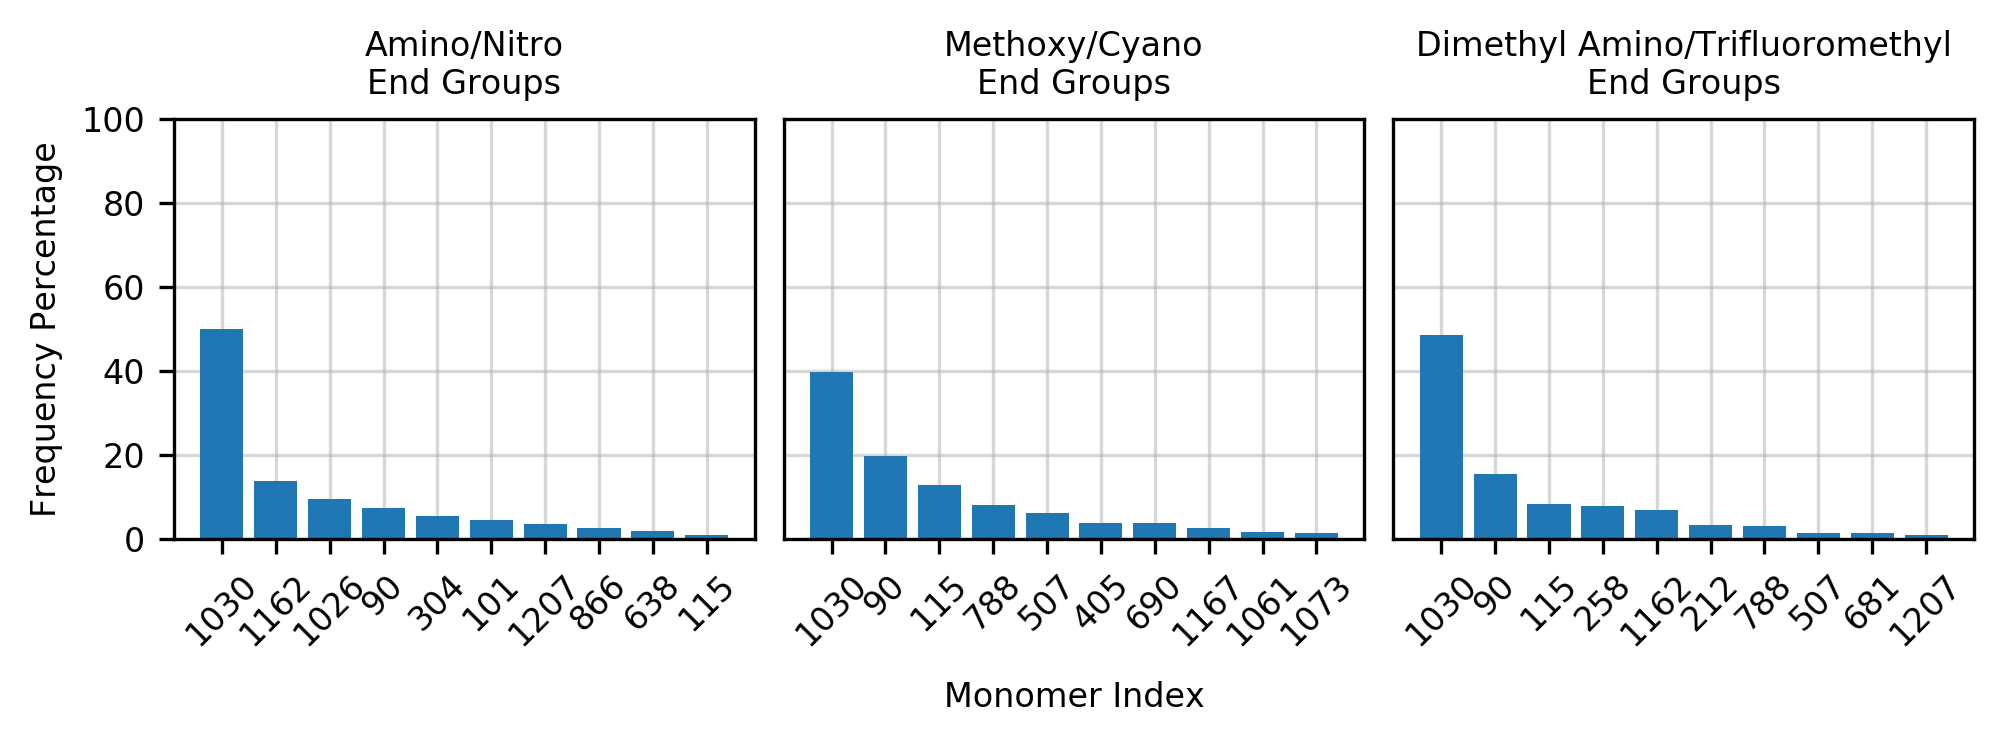

In [16]:
fig, axs = plt.subplots(1, 3, sharey=True, dpi=300)

rot=45
wt='bold'

plt.rcParams["font.weight"] = 'regular'

axs[0].bar('bin3_mono', 'bin3_mono_perc', data=bin3_mcounts_n)
axs[0].set_title('%s\nEnd Groups' % run_name_n)
axs[0].set_xticklabels(bin3_mcounts_n['bin3_mono'], rotation=rot)
axs[0].set(ylim=(0, 100))

axs[0].grid(alpha=0.5)
axs[0].set_axisbelow(True)

axs[1].bar('bin3_mono', 'bin3_mono_perc', data=bin3_mcounts_co)
axs[1].set_title('%s\nEnd Groups' % run_name_co)
axs[1].set_xticklabels(bin3_mcounts_co['bin3_mono'], rotation=rot)

axs[1].grid(alpha=0.5)
axs[1].set_axisbelow(True)

for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

axs[2].bar('bin3_mono', 'bin3_mono_perc', data=bin3_mcounts_cf3)
axs[2].set_title('%s\nEnd Groups' % run_name_cf3)
axs[2].set_xticklabels(bin3_mcounts_cf3['bin3_mono'], rotation=rot)

axs[2].grid(alpha=0.5)
axs[2].set_axisbelow(True)

for tic in axs[2].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

top = 0.5
bottom = 0.15
left = 0
right = 1

fig.text((left+right)/2, 0.01,'Monomer Index', ha='center')
fig.text(-0.08, (top+bottom)/2,'Frequency Percentage', va='center', rotation='vertical')

plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.55, wspace=0.05)

# plt.savefig('equalize_monomers.png', transparent=False, bbox_inches='tight')

plt.show()


### Sequence Plot

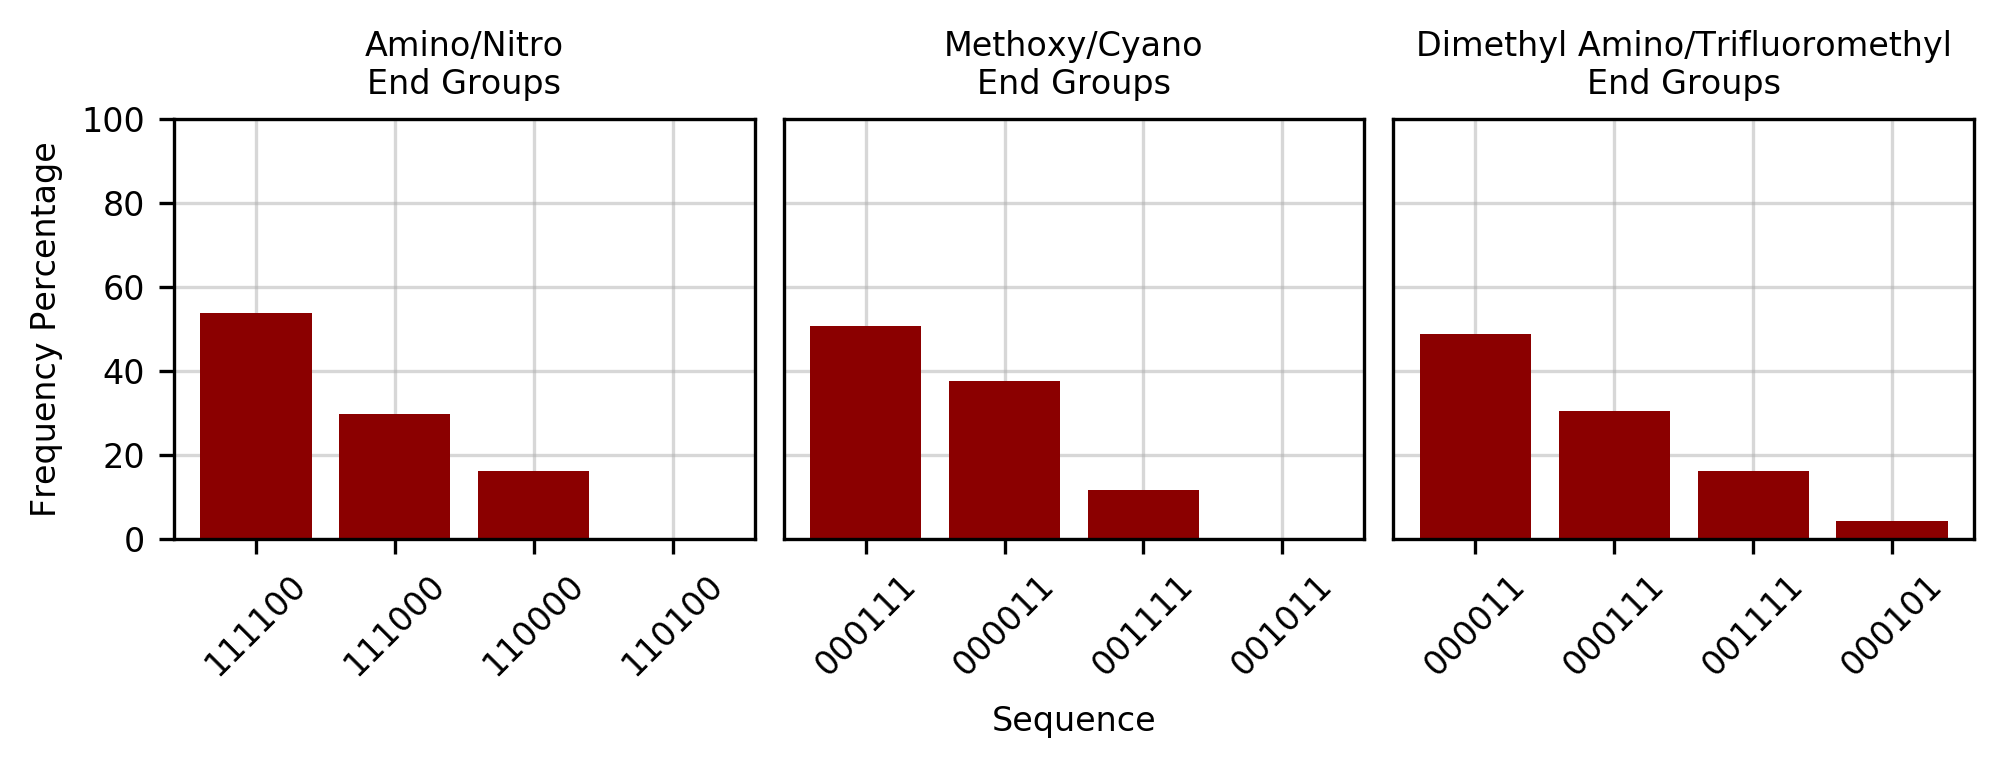

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, dpi=300)

rot=45
wt='bold'
clr = 'darkred'

plt.rcParams["font.weight"] = 'regular'

axs[0].bar('bin3_seq', 'bin3_seq_perc', data=bin3_scounts_n, color=clr)
axs[0].set_title('%s\nEnd Groups' % run_name_n)
axs[0].set_xticklabels(bin3_scounts_n['bin3_seq'], rotation=rot)
axs[0].set(ylim=(0, 100))

axs[0].grid(alpha=0.5)
axs[0].set_axisbelow(True)

axs[1].bar('bin3_seq', 'bin3_seq_perc', data=bin3_scounts_co, color=clr)
axs[1].set_title('%s\nEnd Groups' % run_name_co)
axs[1].set_xticklabels(bin3_scounts_co['bin3_seq'], rotation=rot)

axs[1].grid(alpha=0.5)
axs[1].set_axisbelow(True)

for tic in axs[1].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False

axs[2].bar('bin3_seq', 'bin3_seq_perc', data=bin3_scounts_cf3, color=clr)
axs[2].set_title('%s\nEnd Groups' % run_name_cf3)
axs[2].set_xticklabels(bin3_scounts_cf3['bin3_seq'], rotation=rot)

axs[2].grid(alpha=0.5)
axs[2].set_axisbelow(True)

for tic in axs[2].yaxis.get_major_ticks():
    tic.tick1On = tic.tick2On = False
    
top = 0.5
bottom = 0.15
left = 0
right = 1

fig.text((left+right)/2, -0.01,'Sequence', ha='center')
fig.text(-0.08, (top+bottom)/2,'Frequency Percentage', va='center', rotation='vertical')

plt.subplots_adjust(top=top, bottom=bottom, left=left, right=right, hspace=0.55, wspace=0.05)

# plt.savefig('equalize_sequences.pdf', transparent=False, bbox_inches='tight')
# plt.savefig('equalize_sequences.png', transparent=False, bbox_inches='tight')

plt.show()
